In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
sns.set_theme(style='darkgrid')

In [29]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, pred_to_perf, prob_to_pred
from test import get_training_processed_data
from sklearn.model_selection import train_test_split

In [94]:
import numpy as np
import pandas as pd
import os


def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi.fillna(0)


data_path = 'data/prices.csv'
indices_price_excel = pd.read_csv(data_path, index_col=0, parse_dates=True)
indices_price_excel.drop(columns=['SMIMC Index'], inplace=True)
indices_price_excel.head()
indices_price_excel.columns = ['SPI', 'MID', 'MID_SMALL', 'LARGE']

bench_price = indices_price_excel['SPI']
price = indices_price_excel[indices_price_excel.columns[1:]].shift(1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

# ma200 = price.rolling(window=200).mean()
# ma100 = price.rolling(window=100).mean()
# ma50 = price.rolling(window=50).mean()

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

bench_mom = bench_price.pct_change(periods=21)

upper_bollinger = price.rolling(20).mean() + 2 * price.rolling(20).std()
lower_bollinger = price.rolling(20).mean() - 2 * price.rolling(20).std()
upper_boll_diff = np.log(price / upper_bollinger)
lower_boll_diff = np.log(price / lower_bollinger)

RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

ema_12 = price.ewm(span=12).mean()
ema_26 = price.ewm(span=26).mean()
ema_9 = price.ewm(span=9).mean()
MACD = ema_12 - ema_26
MACD_9 = MACD.ewm(span=9).mean()
MACD_diff = MACD - MACD_9

df_dict = {}
df_input = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([
                        ma50[col], ma100[col], ma200[col],
                        mom12[col], mom6[col], mom1[col],
                        vol12[col], vol6[col], vol1[col],
                        RSI14[col], RSI9[col], RSI3[col], 
                        MACD[col], upper_boll_diff[col], lower_boll_diff[col]
                        ],
                        axis=1).iloc[252:]
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1',
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'RSI3', 'MACD', 'upper_boll_diff', 'lower_boll_diff'
                       ]
    df_dict[col] = df_temp

df_input = pd.concat(df_dict, axis=1)#.dropna(axis=0, how='any')

In [100]:
5e-3

0.005

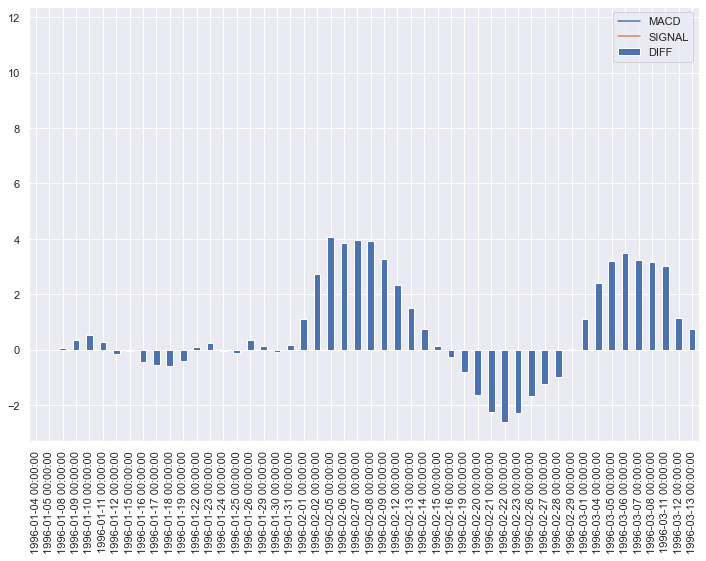

In [99]:
fig, ax = plt.subplots(figsize=(12,8))

MACD['MID'][:50].plot(ax=ax, label='MACD')
MACD_9['MID'][:50].plot(ax=ax, label='SIGNAL')
MACD_diff['MID'][:50].plot(ax=ax, label='DIFF', kind='bar')
plt.legend()
plt.show()

In [3]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

In [30]:
# Get data
price, _, df_input_all = get_price_data()

# Data parameters
rebalance_freq = 'W-FRI'
input_period = 42
training_window = 6

# Process data
X, y = get_training_processed_data(df_input_all, price, rebalance_freq, input_period, training_window)
train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, stratify=y, test_size=0.3)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]

In [55]:
class_count = np.unique(y, axis=0, return_counts=True)[1]
print(class_count)

weight = 1. / class_count
samples_weight = np.array([weight[t] for t in y])

[120  96  98]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [60]:
import torch
numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])
print(class_sample_count)

[900 100]


In [63]:
class_count = np.unique(y, axis=0, return_counts=True)[1]
print(class_count)

weights = class_count / sum(class_count)
print(weights)

[120  96  98]
[0.38216561 0.30573248 0.31210191]


In [37]:
pd.DataFrame(np.array(y)).sum() / len(y)

0    0.312102
1    0.305732
2    0.382166
dtype: float32

In [39]:
pd.DataFrame(np.array(y_train)).sum() / len(y_train)

0    0.310502
1    0.305936
2    0.383562
dtype: float32

In [40]:
pd.DataFrame(np.array(y_test)).sum() / len(y_test)

0    0.315789
1    0.305263
2    0.378947
dtype: float32

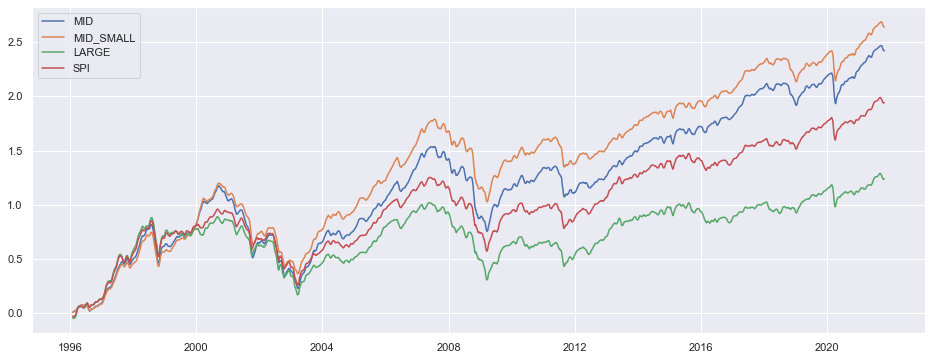

In [4]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = (pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean()
sns.lineplot(data=np.log(data_plot), dashes=False)
plt.show()

In [10]:
models_list = ['MLP', 'ConvNet', 'LSTM']
# models_list = ['MLP', 'ConvNet']
# models_list = ['MLP']
df_pred_dict = {}
df_prob_dict = {}

threshold = 0.8
batch_size = 10
verbose = 0
training_window = 5
nb_epochs = 2
rebalance_freq = 'W-FRI'
input_period_days = 42
input_period_weeks = 8
eta = 5e-4
weight_decay = 1e-4

if rebalance_freq == 'M':
    input_period = input_period_weeks
else:
    input_period = input_period_days

for i, model_name in enumerate(models_list):
    df_prob_dict[model_name] = backtest_strat(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                              model_name=model_name, nb_epochs=nb_epochs, 
                                              input_period=input_period, 
                                              batch_size=batch_size, verbose=verbose, 
                                              training_window=training_window, threshold=threshold, 
                                              eta=eta, weight_decay=weight_decay)
    df_pred_dict[model_name] = prob_to_pred(df_prob_dict[model_name], threshold)

    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]

df_prob_dict['Ensemble'] /= len(models_list)
df_pred_dict['Ensemble'] = prob_to_pred(df_prob_dict[model_name], threshold)

Backtesting model MLP


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Backtesting model ConvNet


100%|██████████| 40/40 [00:06<00:00,  5.91it/s]


Backtesting model LSTM


100%|██████████| 40/40 [00:23<00:00,  1.67it/s]


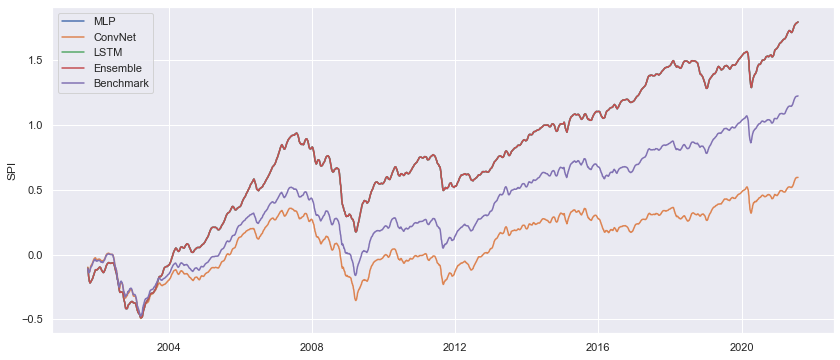

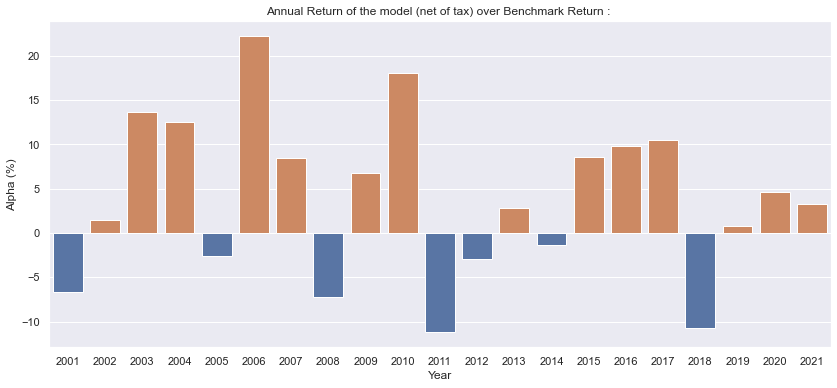

Gross avg. annual return (%)  Net avg. annual return (%)  Avg. annual vol. (%)  Avg Sharpe ratio  Max. Drawdown (%)  Turnover
Benchmark SPI                          7.47                        7.47                 17.40              0.43              44.52         0
MLP                                   11.32                       11.32                 14.43              0.78              47.72         0
ConvNet                                4.39                        4.39                 18.23              0.24              45.09         0
LSTM                                  11.32                       11.32                 14.43              0.78              47.72         0
Ensemble                              11.32                       11.32                 14.43              0.78              47.72         0

In [11]:
df_resume = resume_backtest(df_pred_dict, bench_price, price)
daily_returns = price.pct_change().shift(1)
perf_bench = price_to_perf(bench_price.loc[df_pred_dict['Ensemble'].index[0]:df_pred_dict['Ensemble'].index[-1]], log=False)
performance_plot(df_pred_dict, daily_returns, bench_price, log=True)
annual_alpha_plot(perf_bench, df_pred_dict['Ensemble'], daily_returns)
display(df_resume)

In [12]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

MLP  ConvNet  LSTM
MLP      1.0      0.0   1.0
ConvNet  0.0      1.0   0.0
LSTM     1.0      0.0   1.0

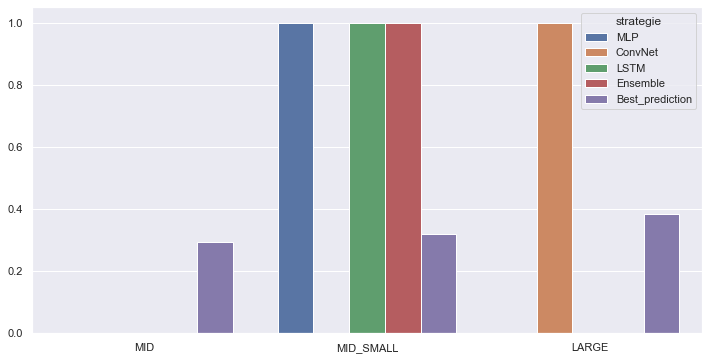

In [13]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()